# Лабораторная работа №2
## Кочеганова Лилия 17-АС
### Вариант 11 (зоопарк)
### Цель работы: получение навыков работы с методами классификации.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings

from sklearn import datasets
from sklearn.linear_model import perceptron
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from matplotlib.pylab import rc, plot
warnings.filterwarnings("ignore")
%matplotlib inline

df = pd.read_csv(r'zoo.csv')
df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


### Описать признаки, используемые в наборе данных 

|Аттрибут|Описание|Тип аттрибута|
|---|---|---|
|animal_name|Имя животного|Строка|
|hair|Наличие волос|Бинарный|
|feathers|Наличие перьев|Бинарный|
|eggs|Откладывает ли яйца|Бинарный|
|milk|Вырабатывает ли молоко|Бинарный|
|airborne|Летает ли|Бинарный|
|aquatic|Плавает ли|Бинарный|
|predator|Является ли хищником|Бинарный|
|toothed|Имеет ли зубы|Бинарный|
|backbone|Имеет ли позвоночник|Бинарный|
|breathes|Дышит ли|Бинарный|
|venomous|Ядовит ли|Бинарный|
|fins|Имеет ли плавники|Бинарный|
|legs|Количество ног|Число: {0,2,4,6,8}|
|tail|Имеет ли хвост|Бинарный|
|domestic|Одомашнен ли|Бинарный|
|catsize|???|Бинарный|
|class_type|Класс|Число: 1 - Млекопитающее, 2 - Птица, 3 - Рептилия, 4 - Рыба, 5 - Амфибия, 6 - Насекомое, 7 - Беспозвоночное|

### Удалить дубликаты

In [16]:
print('Size before dropping duplicates: {}'.format(df.shape))
df = df.drop_duplicates()
print('Size after dropping duplicates: {}'.format(df.shape))

Size before dropping duplicates: (101, 18)
Size after dropping duplicates: (101, 18)


### Оцените сбалансированность данных по классам

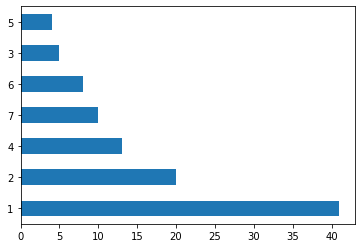

In [17]:
df.class_type.value_counts().plot(kind='barh')

Классы несбалансированны, поэтому для оценки качества классификации будем использовать PR-кривую, поскольку в случае несбалансированности классов она показывает лучшие результаты, чем ROC-кривая

### Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию)

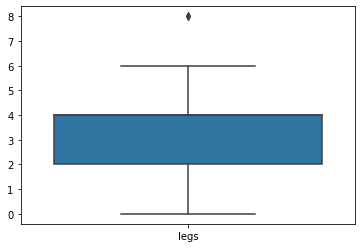

In [18]:
numeric_attributes = ['legs']
sns.boxplot(data=df[numeric_attributes])

Нормализуем данные

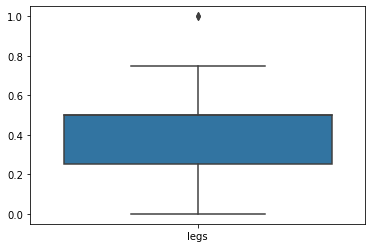

In [19]:
scaler = preprocessing.MinMaxScaler()
df[numeric_attributes] = scaler.fit_transform(df[numeric_attributes].values.astype(float))
sns.boxplot(data=df[numeric_attributes])

### Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других

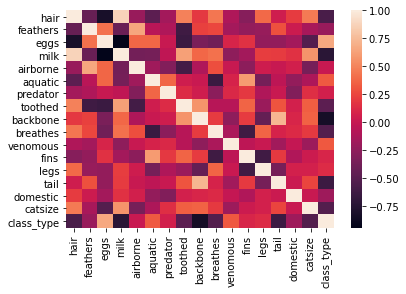

In [20]:
sns.heatmap(df.corr())

Удалим признаки feathers, milk. backbone, поскольку они однозначно определяют класс животного

In [21]:
df.drop(['feathers', 'milk', 'backbone', 'animal_name'], axis=1, inplace=True)
df.head()

,hair,eggs,airborne,aquatic,predator,toothed,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,1,0,0,0,1,1,1,0,0,0.5,0,0,1,1
1,1,0,0,0,0,1,1,0,0,0.5,1,0,1,1
2,0,1,0,1,1,1,0,0,1,0.0,1,0,0,4
3,1,0,0,0,1,1,1,0,0,0.5,0,0,1,1
4,1,0,0,0,1,1,1,0,0,0.5,1,0,1,1


### Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества)

In [22]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('predator', axis=1), df['predator']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(70, 13)
(31, 13)


In [23]:
rnc = RadiusNeighborsClassifier(outlier_label=1)

params = {'radius': np.arange(0, 5, 0.25)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, '\t at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score: 0.6428571428571428 	 at radius: 1.0
test score:  0.6451612903225806


In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

X, Y = df.drop('class_type', axis=1), df['class_type']
Y = label_binarize(Y, classes=[x for x in range(7)])
n_classes = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [25]:
clf_perceptron = OneVsRestClassifier(linear_model.Perceptron())
params = {
      'estimator__alpha': np.linspace(0, 1, 50)[1:],
      'estimator__max_iter': [(x+1)*10 for x in range(5)],
      }
param_search = GridSearchCV(estimator=clf_perceptron, param_grid=params)
param_search.fit(X_train, Y_train)
Y_score = param_search.best_estimator_.fit(X_train, Y_train).decision_function(X_test)
print('Accuracy: {}'.format(accuracy_score(param_search.best_estimator_.predict(X_test), Y_test)))
print('Best score: {}'.format(param_search.best_score_))

Accuracy: 0.8709677419354839
Best score: 0.8


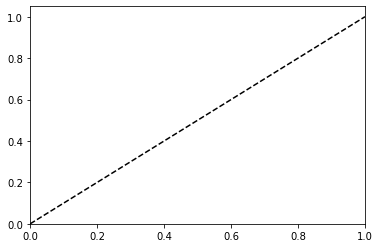

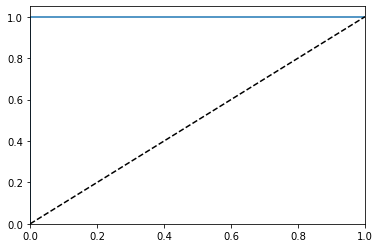

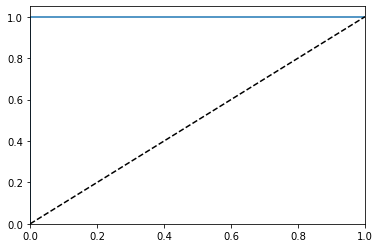

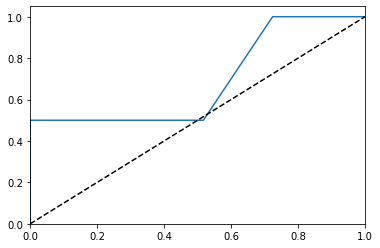

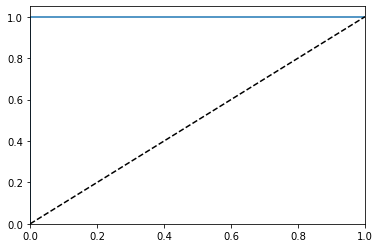

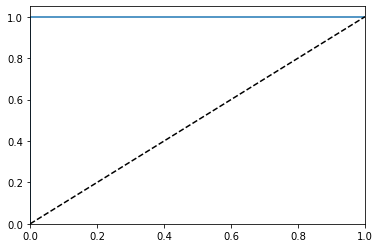

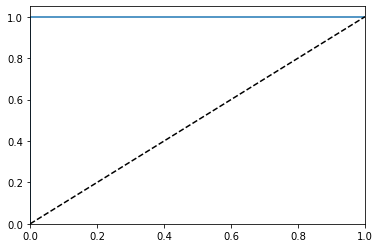

In [26]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

Average precision score, micro-averaged over all classes: 0.93


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.93')

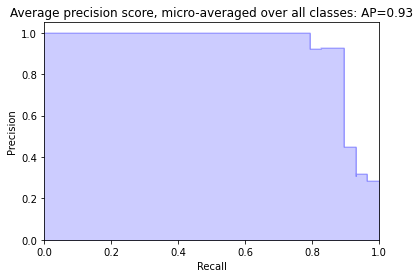

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        Y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], Y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    Y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, Y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [28]:
from sklearn import tree

clf_tree = OneVsRestClassifier(tree.DecisionTreeClassifier())
clf_tree.get_params()
params = {
      'estimator__max_depth': [x+1 for x in range(10)],
      'estimator__max_features': [x+1 for x in range(10)],
      }
param_search = GridSearchCV(estimator=clf_tree, param_grid=params)
param_search.fit(X_train, Y_train)
print('Accuracy: {}'.format(accuracy_score(param_search.best_estimator_.predict(X_test), Y_test)))
print('Best score: {}'.format(param_search.best_score_))

param_search.best_estimator_.fit(X_train, Y_train)
Y_score = param_search.best_estimator_.predict(X_test)

Accuracy: 0.9032258064516129
Best score: 0.8571428571428573


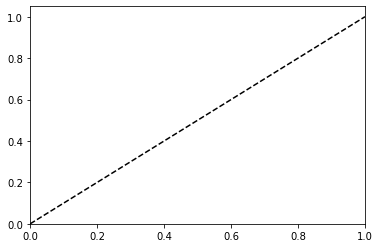

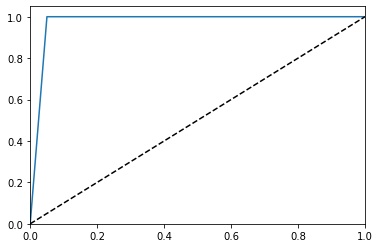

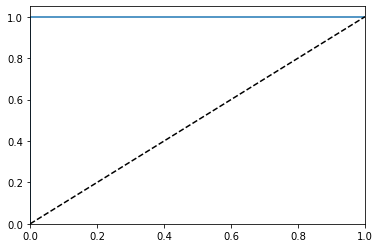

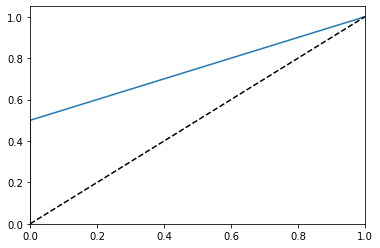

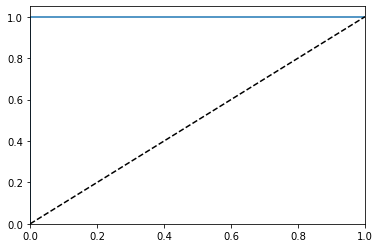

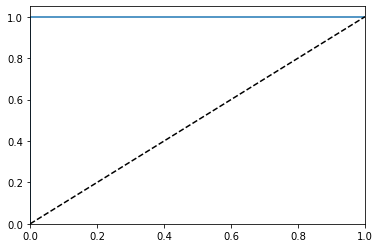

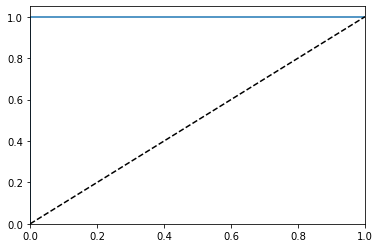

In [29]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

Average precision score, micro-averaged over all classes: 0.94


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.94')

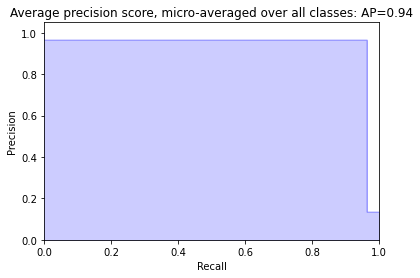

In [30]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        Y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], Y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    Y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, Y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))